In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [6]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [7]:
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])
df = df.set_index('Month_Invoiced').sort_index()

In [8]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [22]:
df_resampled = df.resample('M')[['Amount']].sum()
df_resampled

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [23]:
df_resampled.shape

(48, 1)

In [24]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

24

In [25]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

14

In [26]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

10

In [27]:
len(df_resampled) == train_size + validate_size + test_size

True

In [28]:
# validate will go from 913 to 913+548
validate_end_index = train_size + validate_size
validate_end_index

38

In [29]:
train = df_resampled[:train_size]

In [30]:
val = df_resampled[train_size:validate_end_index]

In [31]:
test = df_resampled[validate_end_index:]

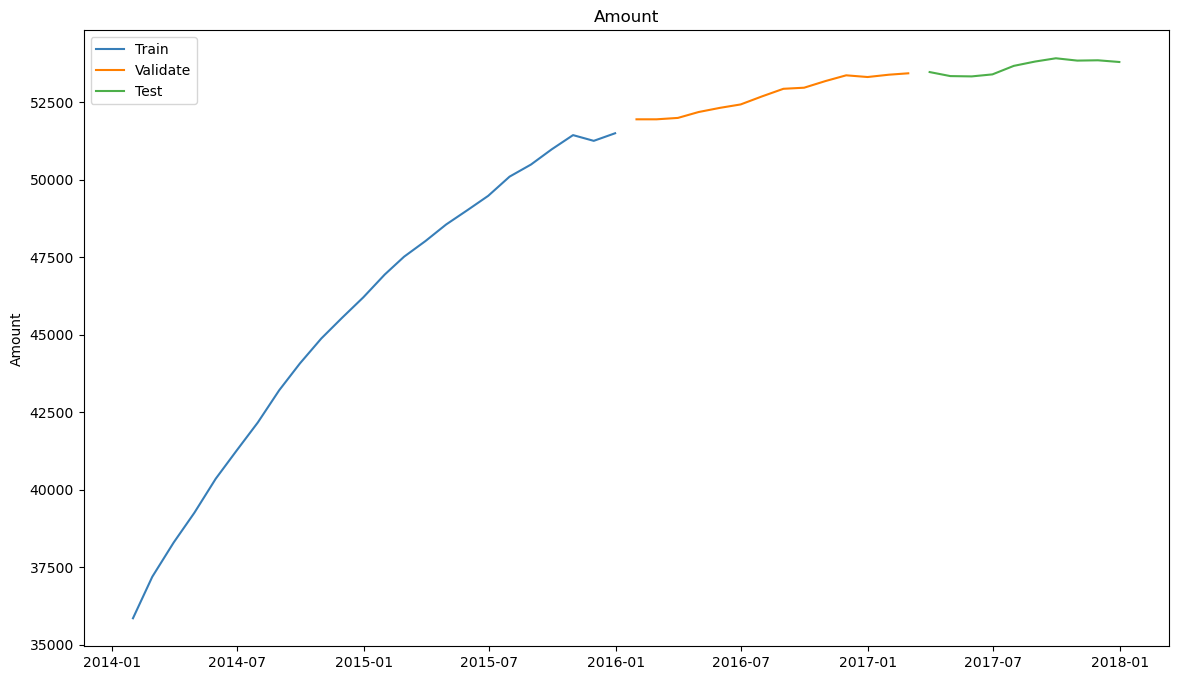

In [32]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(val[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [33]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(val[target_var], yhat_df[target_var])), 0)
    return rmse

In [34]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(val[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [35]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [36]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [38]:
last_date = train['Amount'][-1:][0]

In [42]:
yhat_df = pd.DataFrame(
    {'Amount': last_date},
    index=val.index)

yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


Amount -- RMSE: 1343


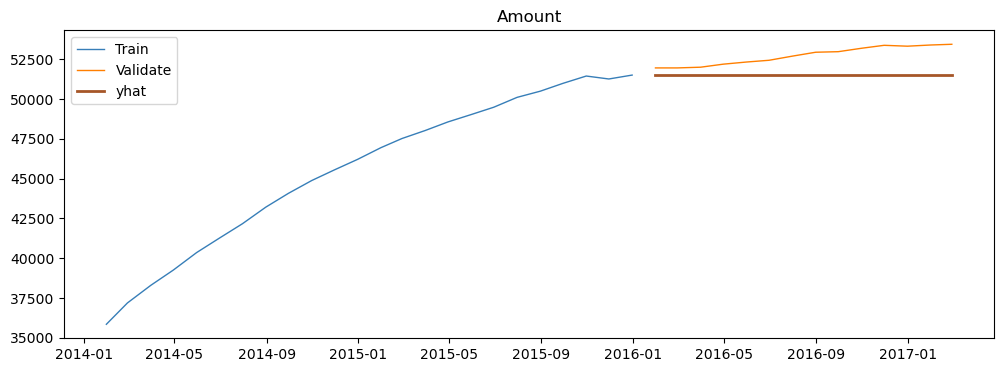

In [43]:
for col in train.columns:
    plot_and_eval(col)

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


In [45]:
avg_amount = round(train['Amount'].mean(), 2)
avg_amount

45568.54

In [46]:
def make_baseline_predictions(predictions=None):
    yhat_df = pd.DataFrame({'Amount': [predictions]},
                          index=val.index)
    return yhat_df

In [47]:
yhat_df = make_baseline_predictions(avg_amount)

In [48]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


Amount -- RMSE: 7181


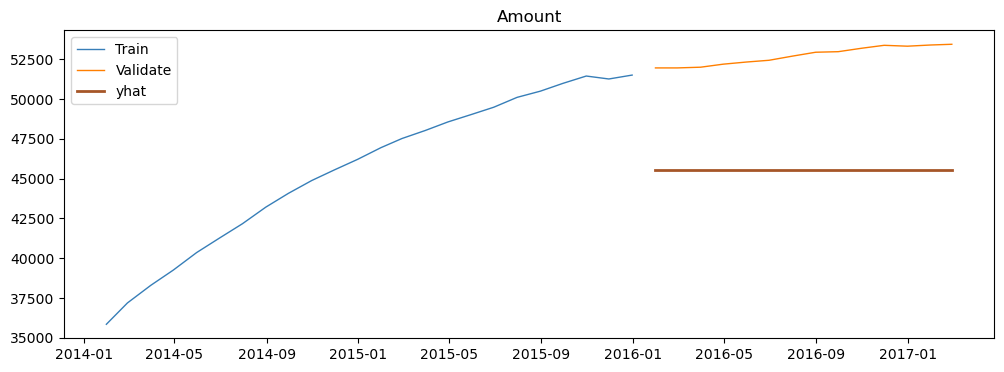

In [49]:
for col in train.columns:
    plot_and_eval(col)

In [50]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0


In [55]:
period=3
train['Amount'].rolling(period).mean()

Month_Invoiced
2014-01-31             NaN
2014-02-28             NaN
2014-03-31    37111.666667
2014-04-30    38246.666667
2014-05-31    39301.666667
2014-06-30    40288.333333
2014-07-31    41260.000000
2014-08-31    42211.666667
2014-09-30    43151.666667
2014-10-31    44055.000000
2014-11-30    44833.333333
2014-12-31    45545.000000
2015-01-31    46233.333333
2015-02-28    46891.666667
2015-03-31    47496.666667
2015-04-30    48035.000000
2015-05-31    48536.666667
2015-06-30    49023.333333
2015-07-31    49538.333333
2015-08-31    50028.333333
2015-09-30    50528.333333
2015-10-31    50975.000000
2015-11-30    51230.000000
2015-12-31    51403.333333
Freq: M, Name: Amount, dtype: float64

In [56]:
period=3
train['Amount'].rolling(period).mean()[-1]

51403.333333333336

In [57]:
rolling_avg = round(train['Amount'].rolling(period).mean()[-1], 2)

In [58]:
yhat_df = make_baseline_predictions(rolling_avg)
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


Amount -- RMSE: 1436


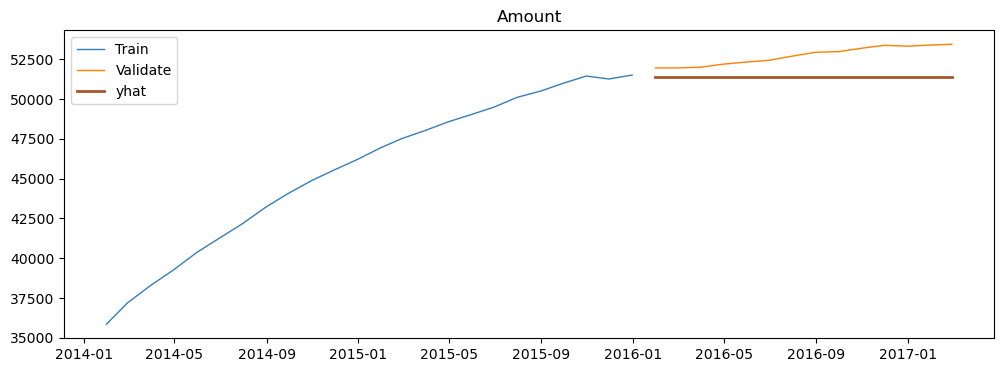

In [59]:
for col in train.columns:
    plot_and_eval(col)

In [60]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '3m_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,3m_moving_avg,Amount,1436.0


In [61]:
periods = [1,2,3,5]

for p in periods: 
    rolling_avg = round(train['Amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_avg)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [62]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,3m_moving_avg,Amount,1436.0
3,1_day_moving_avg,Amount,1343.0
4,2_day_moving_avg,Amount,1455.0
5,3_day_moving_avg,Amount,1436.0
6,5_day_moving_avg,Amount,1684.0


In [64]:
best_quantity_rmse = eval_df[eval_df.target_var == 'Amount']['rmse'].min()
best_quantity_rmse

1343.0

In [65]:
eval_df[eval_df.rmse == best_quantity_rmse]

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
3,1_day_moving_avg,Amount,1343.0


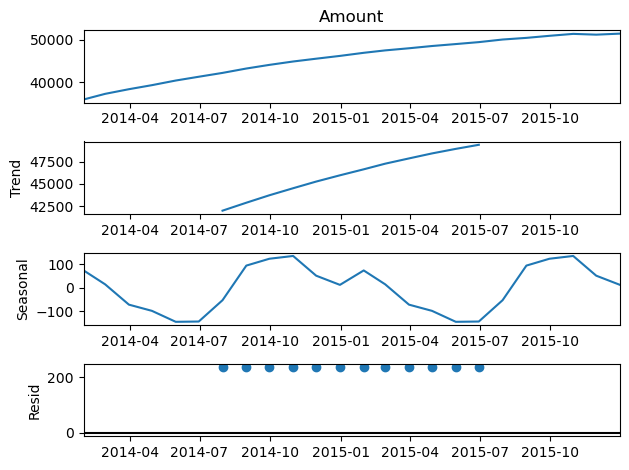

In [68]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

In [69]:
col = 'Amount' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [70]:
# fit the Holt object
model = model.fit(optimized=True)

In [71]:
yhat_sales_total = model.predict(start = val.index[0],
                              end = val.index[-1])

In [72]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = val.index[0],
                              end = val.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [73]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04


Amount -- RMSE: 456


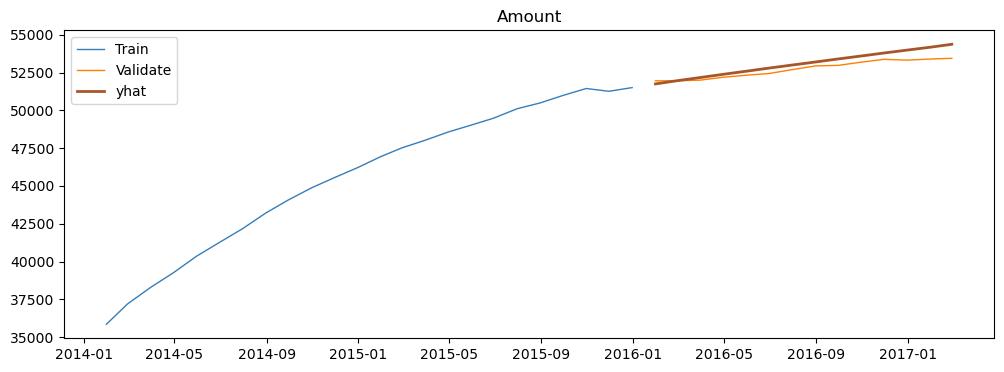

In [74]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [75]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [76]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
7,holts_optimized,Amount,456.0
0,last_observed_value,Amount,1343.0
3,1_day_moving_avg,Amount,1343.0
2,3m_moving_avg,Amount,1436.0
5,3_day_moving_avg,Amount,1436.0
4,2_day_moving_avg,Amount,1455.0
6,5_day_moving_avg,Amount,1684.0
1,simple_average,Amount,7181.0


In [83]:
# Models for quantity
hst_amount_fit1 = ExponentialSmoothing(train['Amount'], seasonal_periods=12, trend='add', seasonal='add').fit()
hst_amount_fit2 = ExponentialSmoothing(train['Amount'], seasonal_periods=12, trend='add', seasonal='mul').fit()
hst_amount_fit3 = ExponentialSmoothing(train['Amount'], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()
hst_amount_fit4 = ExponentialSmoothing(train['Amount'], seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [84]:
hst_amount_fit1.params

{'smoothing_level': 0.9318571413670268,
 'smoothing_trend': 0.09327645138539839,
 'smoothing_seasonal': 8.100000177127001e-05,
 'damping_trend': nan,
 'initial_level': 40238.58055555555,
 'initial_trend': -842.1214646464601,
 'initial_seasons': array([-1253.01180556,   -31.97847222,   -29.18680556,  -112.24513889,
          -85.21180556,  -134.76180556,   -10.67847222,    67.21319444,
          141.57986111,   250.15486111,   -13.95347222,   -78.02013889]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [86]:
results_amount=pd.DataFrame({'model':['hst_amount_fit1', 'hst_amount_fit2', 'hst_amount_fit3', 'hst_amount_fit4'],
                              'SSE':[hst_amount_fit1.sse, hst_amount_fit2.sse, hst_amount_fit3.sse, hst_amount_fit4.sse]})
results_amount

,model,SSE
0,hst_amount_fit1,3.021176e+07
1,hst_amount_fit2,4.386029e+07
2,hst_amount_fit3,3.086059e+06
3,hst_amount_fit4,4.318860e+07


In [87]:
results_amount.sort_values(by='SSE')

,model,SSE
2,hst_amount_fit3,3.086059e+06
0,hst_amount_fit1,3.021176e+07
3,hst_amount_fit4,4.318860e+07
1,hst_amount_fit2,4.386029e+07


In [88]:
yhat_df = pd.DataFrame({'Amount': hst_amount_fit1.forecast(val.shape[0])},
                          index=val.index)
yhat_df

,Amount
Month_Invoiced,
2016-01-31,50664.684239
2016-02-29,52217.428386
2016-03-31,52552.052536
2016-04-30,52800.651668
2016-05-31,53159.313742
2016-06-30,53441.400957
2016-07-31,53897.114054
2016-08-31,54306.650282
2016-09-30,54712.659129


Amount -- RMSE: 1502


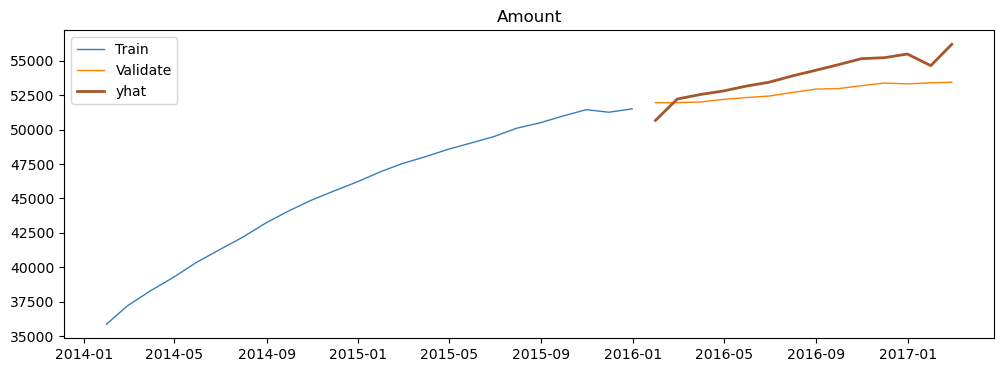

In [89]:
for col in train.columns:
    plot_and_eval(col)

In [90]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,3m_moving_avg,Amount,1436.0
3,1_day_moving_avg,Amount,1343.0
4,2_day_moving_avg,Amount,1455.0
5,3_day_moving_avg,Amount,1436.0
6,5_day_moving_avg,Amount,1684.0
7,holts_optimized,Amount,456.0


In [91]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [92]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
7,holts_optimized,Amount,456.0
0,last_observed_value,Amount,1343.0
3,1_day_moving_avg,Amount,1343.0
2,3m_moving_avg,Amount,1436.0
5,3_day_moving_avg,Amount,1436.0
4,2_day_moving_avg,Amount,1455.0
8,holts_seasonal_add_add,Amount,1502.0
6,5_day_moving_avg,Amount,1684.0
1,simple_average,Amount,7181.0


In [93]:
train = df_resampled[:'2015']
val = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(val.shape)
print(test.shape)

train.head()
train.tail()

(24, 1)
(12, 1)
(12, 1)


,Amount
Month_Invoiced,
2015-08-31,50495.0
2015-09-30,50985.0
2015-10-31,51445.0
2015-11-30,51260.0
2015-12-31,51505.0


In [94]:
train.diff(12)

,Amount
Month_Invoiced,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,NaN
2014-05-31,NaN
2014-06-30,NaN
2014-07-31,NaN
2014-08-31,NaN
2014-09-30,NaN


In [95]:
yhat_df = train['2015'] + train.diff(12).mean()
yhat_df

,Amount
Month_Invoiced,
2015-01-31,55033.75
2015-02-28,55608.75
2015-03-31,56113.75
2015-04-30,56648.75
2015-05-31,57113.75
2015-06-30,57573.75
2015-07-31,58193.75
2015-08-31,58583.75
2015-09-30,59073.75


In [96]:
train.diff(12).mean()

Amount    8088.75
dtype: float64

In [97]:
train.loc['2015'].head()

,Amount
Month_Invoiced,
2015-01-31,46945.0
2015-02-28,47520.0
2015-03-31,48025.0
2015-04-30,48560.0
2015-05-31,49025.0


In [98]:
pd.concat([yhat_df.head(1), val.head(1)])

,Amount
Month_Invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [99]:
yhat_df.index = val.index

Amount -- RMSE: 5192


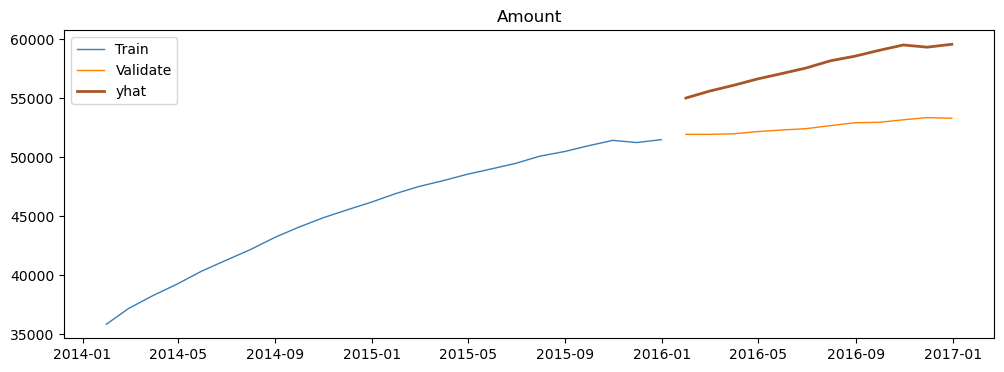

In [100]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [101]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
7,holts_optimized,Amount,456.0
0,last_observed_value,Amount,1343.0
3,1_day_moving_avg,Amount,1343.0
2,3m_moving_avg,Amount,1436.0
5,3_day_moving_avg,Amount,1436.0
4,2_day_moving_avg,Amount,1455.0
8,holts_seasonal_add_add,Amount,1502.0
6,5_day_moving_avg,Amount,1684.0
9,previous_year,Amount,5192.0
1,simple_average,Amount,7181.0


In [102]:
amount_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

# find which model that is
eval_df[((eval_df.rmse == amount_min_rmse))]

,model_type,target_var,rmse
7,holts_optimized,Amount,456.0


In [103]:
train = df_resampled[:train_size]
val = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [115]:
yhat_df = pd.DataFrame({'Amount': hst_amount_fit1.forecast(val.shape[0] + test.shape[0])})
yhat_df

,Amount
2016-01-31,50664.684239
2016-02-29,52217.428386
2016-03-31,52552.052536
2016-04-30,52800.651668
2016-05-31,53159.313742
2016-06-30,53441.400957
2016-07-31,53897.114054
2016-08-31,54306.650282
2016-09-30,54712.659129
2016-10-31,55152.870112


In [120]:
test

,Amount
Month_Invoiced,
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0
2017-08-31,53820.0
2017-09-30,53925.0
2017-10-31,53850.0
2017-11-30,53860.0


In [121]:
yhat_df = yhat_df['2017-03-01':]

In [116]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(val[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [117]:
yhat_df

,Amount
2016-01-31,50664.684239
2016-02-29,52217.428386
2016-03-31,52552.052536
2016-04-30,52800.651668
2016-05-31,53159.313742
2016-06-30,53441.400957
2016-07-31,53897.114054
2016-08-31,54306.650282
2016-09-30,54712.659129
2016-10-31,55152.870112


In [122]:
rmse_amount_total = sqrt(mean_squared_error(test['Amount'], 
                                       yhat_df['Amount']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  4477.009027449267


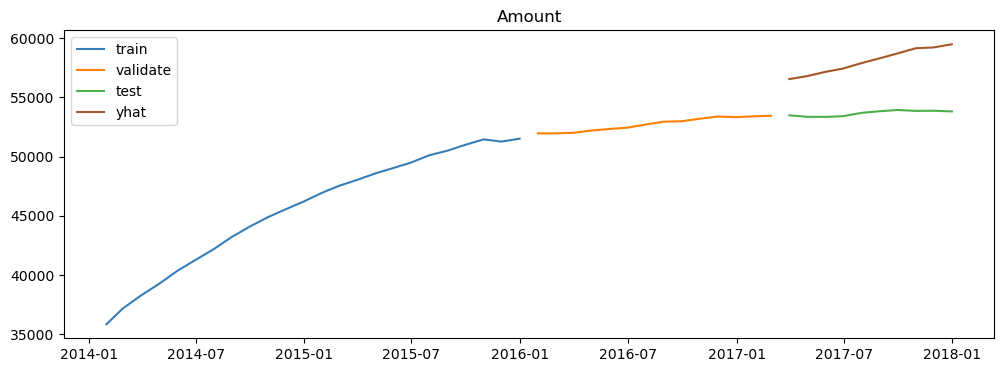

In [125]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_amount_total)
for col in train.columns:
    final_plot(col)